## EXPLICIT ATM

In [ ]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline
from scipy import stats


In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [ ]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)

# Pre-generate 10 unique seeds
ga_runs=10
seeds_for_runs = np.random.randint(0, 10**6, size=ga_runs)


In [4]:
#Simulation parameters
T = 1.0                 # Time horizon (years)
N = 252                 # Number of time steps
dt = T / N              # Time increment
M = 10000                # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                       # Speed of mean reversion for interest rate                             # Escobar
varphi_r=0.0025                                     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
print("varphi_r/kappa_r: ", varphi_r / kappa_r)     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0.0566                                     # Volatility of the interest rate                                       # Escobar
r0 = varphi_r / kappa_r                             # Initial interest rate                                                 # Escobar

#Bond parameters
lambda_r = -0.1132                                  # Risk premium on interest rate                                         # Escobar
T_tilde = T                                         # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                    # Speed of mean reversion for variance                                  # Escobar
varphi_v= 0.0563                                    # varphi_v/kappa_v is the long-run variance                             # Escobar
print("varphi_v/kappa_v: ", varphi_v / kappa_v)     # varphi_v/kappa_v is the long-run variance                             # Escobar
sigma_v = 0.2941                                    # Volatility of variance process                                        # Escobar
V0 = varphi_v / kappa_v                             # Initial variance                                                      # Escobar    
rho = -0.23                                         # Correlation between stock and variance shocks                         # Escobar                                  
lambda_v= -6.6932                                   # Risk premium on variance                                              # Escobar                 

# Parameters for stock price process
S0 = 100                                            # Initial stock price                                                   # Escobar
lambda_s = 2.2472                                   # Risk premium on diffusive risk                                        # Escobar                        
nu=-0.5973                                          # Factor loading stock and rate                                         # Escobar 
lambda_j = 12.3                                     # Jump intensity                                                        # Pan
lambda_j_q = lambda_j*2                             # Jump intensity Q                                                      # Liu and Pan
mu= -0.10                                           # Jump amplitude                                                        # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                                      # Jump frequency                                                        # Liu and Pan

# Parameters for option pricing 
num_K= 9                                            # Number of strikes         

# General parameters
gamma= 3                                            # Risk aversion parameter                                              # Liu and Pan
num_options= 5

#Sensitivity parameters
vals = 10 # Number of values for the sensitivity analysis
num_runs = 10  # Number of runs of GA per sensitivity analysis


varphi_r/kappa_r:  0.019230769230769232
varphi_v/kappa_v:  0.019909470259565742


In [5]:
# Function for b(T-t)
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    num = 2 * (np.exp(xi * (T_tilde - t)) - 1)
    den = 2 * xi + (xi + kappa_r + lambda_r) * (np.exp(xi * (T_tilde - t)) - 1)
    return num / den

In [6]:
print("Expected return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Expected return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)

Expected return on stock:  0.11921014430729271
Expected return on bond:  0.021388365884807477


In [7]:
# Allocate result arrays
call_prices = np.zeros((M, N + 1, num_K))
put_prices = np.zeros((M, N + 1, num_K))
delta_call = np.zeros((M, N + 1, num_K))
delta_put = np.zeros((M, N + 1, num_K))
vega_call = np.zeros((M, N + 1, num_K))
vega_put = np.zeros((M, N + 1, num_K))
rho_call = np.zeros((M, N + 1, num_K))
rho_put = np.zeros((M, N + 1, num_K))
jump_call = np.zeros((M, N + 1, num_K))
jump_put = np.zeros((M, N + 1, num_K))

# Paths
S_paths = np.zeros((M, N + 1))
V_paths = np.zeros((M, N + 1))
r_paths = np.zeros((M, N + 1))
N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1)) 
B= np.zeros((M, N + 1))
M_t= np.zeros((M, N + 1))
dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))

sqrt_1_minus_rho2 = np.sqrt(1 - rho**2)

def simulation(S_t, V_t, r_t):
    S_paths[:, 0] = S_t
    V_paths[:, 0] = V_t
    r_paths[:, 0] = r_t
    B[:, 0] = 1
    M_t[:, 0] = 1

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock Diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + sqrt_1_minus_rho2 * dW_s[:, j]) * S_prev+ nu*sigma_r*np.sqrt(r_prev)*dW_r[:, j]*S_prev
        
        # Jump Term
        jump_term = S_prev * mu * (N_J[:, j]- lambda_j * V_prev * dt)
        
        # Stock Drift
        drift = (r_prev+lambda_v*rho*V_prev+lambda_s*sqrt_1_minus_rho2*V_prev+nu*lambda_r*r_prev+mu*(lambda_j-lambda_j_q)*V_prev) * S_prev * dt

        # Stock Process
        S_new = S_prev + drift + diffusion + jump_term

        # Money Market
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)


        # Bond Process
        t_curr= j *dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t*r_prev) * B[:, j - 1] * dt
        diffusion_B =  -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

    return S_paths, V_paths, r_paths

simulation(S0, V0, r0)

def simulate_bumped_V_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon):
    V_bumped = np.maximum(V_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_bumped * dt)
    drift = (r_curr + lambda_v * rho * V_bumped + lambda_s * np.sqrt(1 - rho**2) * V_bumped +
             nu * lambda_r * r_curr + mu * (lambda_j - lambda_j_q) * V_bumped) * S_curr * dt
    diffusion = (np.sqrt(V_bumped) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_curr) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def simulate_bumped_r_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon):
    r_bumped = np.maximum(r_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_curr * dt)
    drift = (r_bumped + lambda_v * rho * V_curr + lambda_s * np.sqrt(1 - rho**2) * V_curr +
             nu * lambda_r * r_bumped + mu * (lambda_j - lambda_j_q) * V_curr) * S_curr * dt
    diffusion = (np.sqrt(V_curr) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_bumped) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def numerical_option_pricing(S, K):
    return max(S - K, 0), max(K - S, 0)

epsilon_S = 1e-4
epsilon_V = 1e-3  # for Vega
epsilon_r = 1e-3  # for Rho

for i in tqdm(range(M), desc="Simulating Monte Carlo Paths"):
    for j in range(N + 1):
        S_mean = np.mean(S_paths[:, j])
        S_curr = S_paths[i, j]
        strike_prices = np.linspace(S_mean * 0.8, S_mean * 1.2, num_K)
        S_bump_S_up = S_curr + epsilon_S
        S_bump_S_down = S_curr - epsilon_S
        S_bump_jump = S_curr * (1 + mu)

        S_bumped_V = simulate_bumped_V_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_V)
        S_bumped_r = simulate_bumped_r_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_r)

        for k, K in enumerate(strike_prices):
            call, put = numerical_option_pricing(S_curr, K)
            call_prices[i, j, k] = call
            put_prices[i, j, k] = put
            call_V, put_V = numerical_option_pricing(S_bumped_V, K)
            call_r, put_r = numerical_option_pricing(S_bumped_r, K)
            call_S_up, put_S_up = numerical_option_pricing(S_bump_S_up, K)
            call_S_down, put_S_down = numerical_option_pricing(S_bump_S_down, K)
            call_J, put_J = numerical_option_pricing(S_bump_jump, K)

            delta_call[i, j, k] = (call_S_up - call_S_down) / (epsilon_S*2)
            delta_put[i, j, k] = (put_S_up - put_S_down) / (epsilon_S*2)
            vega_call[i, j, k] = (call_V - call) / epsilon_V
            vega_put[i, j, k] = (put_V - put) / epsilon_V
            rho_call[i, j, k] = (call_r - call) / epsilon_r
            rho_put[i, j, k] = (put_r - put) / epsilon_r
            jump_call[i, j, k] = (call_J - call) #/ mu
            jump_put[i, j, k] = (put_J - put) #/ mu

print("Simulation and pricing complete!")

S=S_paths
V=V_paths
r=r_paths

Simulating Monte Carlo Paths: 100%|██████████| 10000/10000 [02:07<00:00, 78.27it/s]


Simulation and pricing complete!


In [ ]:
S_mean = np.mean(S[:, 0])
K_min = 0.8 * S_mean
K_max = 1.2 * S_mean
K_grid = np.linspace(K_min, K_max, num_K)

In [9]:
# Derivative price processes and sensitivities

# Initialize matrices for derivative price processes
O_1 = np.zeros((M, N+1, num_K))
O_2 = np.zeros((M, N+1, num_K))
O_1[:, 0, :] = 1
O_2[:, 0, :] = 1

# Initialize matrices for sensitivities
A1_1 = np.zeros((M, N+1, num_K))
A2_1 = np.zeros((M, N+1, num_K))
A3_1 = np.zeros((M, N+1, num_K))
A4_1 = np.zeros((M, N+1, num_K))
A1_2 = np.zeros((M, N+1, num_K))
A2_2 = np.zeros((M, N+1, num_K))
A3_2 = np.zeros((M, N+1, num_K))
A4_2 = np.zeros((M, N+1, num_K))

def compute_A_O(A1_1, A2_1, A3_1, A4_1, A1_2, A2_2, A3_2, A4_2,
                O_1, O_2, delta_call, rho_call, vega_call, jump_call,
                delta_put, rho_put, vega_put, jump_put,
                S, V, r, dW_s, dW_v, dW_r, N_J,
                rho, nu, sigma_v, lambda_s, lambda_r, lambda_v, lambda_j, lambda_j_q, sigma_r, dt, N, num_K):
    
    eps = 1  # Ensure not divide by zero

    for t in range(1, N + 1):
        for k_idx in range(num_K):

            safe_call_price = call_prices[:, t-1, k_idx]+eps 
            safe_put_price  = put_prices[:, t-1, k_idx]+eps

            A1_1[:, t, k_idx] = delta_call[:, t-1, k_idx] * S[:, t-1] * np.sqrt(1 - rho**2) / safe_call_price
            A2_1[:, t, k_idx] = (delta_call[:, t-1, k_idx] * S[:, t-1] * nu + rho_call[:, t-1, k_idx]) / safe_call_price
            A3_1[:, t, k_idx] = (delta_call[:, t-1, k_idx] * S[:, t-1] * rho + vega_call[:, t-1, k_idx] * sigma_v) / safe_call_price
            A4_1[:, t, k_idx] = jump_call[:, t-1, k_idx] / safe_call_price

            A1_2[:, t, k_idx] = delta_put[:, t-1, k_idx] * S[:, t-1] * np.sqrt(1 - rho**2) / safe_put_price
            A2_2[:, t, k_idx] = (delta_put[:, t-1, k_idx] * S[:, t-1] * nu + rho_put[:, t-1, k_idx]) / safe_put_price
            A3_2[:, t, k_idx] = (delta_put[:, t-1, k_idx] * S[:, t-1] * rho + vega_put[:, t-1, k_idx] * sigma_v) / safe_put_price
            A4_2[:, t, k_idx] = jump_put[:, t-1, k_idx] / safe_put_price

            O_1[:, t, k_idx] = O_1[:, t-1, k_idx] + O_1[:, t-1, k_idx] * (
                r[:, t-1] * dt +
                A1_1[:, t, k_idx] * (lambda_s * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_s[:, t-1]) +
                A2_1[:, t, k_idx] * (lambda_r * r[:, t-1] * dt + sigma_r * np.sqrt(r[:, t-1]) * dW_r[:, t-1]) +
                A3_1[:, t, k_idx] * (lambda_v * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_v[:, t-1]) +
                A4_1[:, t, k_idx] * ((lambda_j - lambda_j_q) * V[:, t-1] * dt + (N_J[:, t]) - lambda_j * V[:, t-1] * dt)
            )
            
            O_2[:, t, k_idx] = O_2[:, t-1, k_idx] + O_2[:, t-1, k_idx] * (
                r[:, t-1] * dt +
                A1_2[:, t, k_idx] * (lambda_s * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_s[:, t-1]) +
                A2_2[:, t, k_idx] * (lambda_r * r[:, t-1] * dt + sigma_r * np.sqrt(r[:, t-1]) * dW_r[:, t-1]) +
                A3_2[:, t, k_idx] * (lambda_v * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_v[:, t-1]) +
                A4_2[:, t, k_idx] * ((lambda_j - lambda_j_q) * V[:, t-1] * dt + (N_J[:, t]) - lambda_j * V[:, t-1] * dt)
            )

    # Ensure no NaN values in the tensors
    for tensor in [A1_1, A2_1, A3_1, A4_1, A1_2, A2_2, A3_2, A4_2, O_1, O_2]:
        tensor[:] = np.nan_to_num(tensor, nan=0.0, posinf=1000.0, neginf=-1000.0)


compute_A_O(A1_1, A2_1, A3_1, A4_1, A1_2, A2_2, A3_2, A4_2,
            O_1, O_2, delta_call, rho_call, vega_call, jump_call,
            delta_put, rho_put, vega_put, jump_put,
            S, V, r, dW_s, dW_v, dW_r, N_J,
            rho, nu, sigma_v, lambda_s, lambda_r, lambda_v, lambda_j, lambda_j_q, sigma_r, dt, N, num_K)

In [10]:
def project_to_sum_one(w):
    return w - (np.sum(w) - 1) / len(w)

In [ ]:
def plot_full_option_strategy_payoff(call_strikes, call_weights, put_strikes, put_weights, pi_weights, S_mean):
    
    S_grid = np.linspace(0.5 * S_mean, 1.5 * S_mean, 500)

    call_payoff = np.zeros_like(S_grid)
    for K, w in zip(call_strikes, call_weights):
        call_payoff += w * np.maximum(S_grid - K, 0)

    put_payoff = np.zeros_like(S_grid)
    for K, w in zip(put_strikes, put_weights):
        put_payoff += w * np.maximum(K - S_grid, 0)

    combined_payoff_weighted = pi_weights[1]*call_payoff + pi_weights[2]*put_payoff
    combined_payoff= call_payoff +put_payoff

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Call
    axes[0,0].plot(S_grid, call_payoff, color="blue")
    axes[0,0].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[0,0].set_title("Call Strategy Payoff")
    axes[0,0].set_xlabel("Stock Price at Maturity")
    axes[0,0].set_ylabel("Payoff")
    axes[0,0].grid(True)
    axes[0,0].legend()

    # Put
    axes[0,1].plot(S_grid, put_payoff, color="red")
    axes[0,1].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[0,1].set_title("Put Strategy Payoff")
    axes[0,1].set_xlabel("Stock Price at Maturity")
    axes[0,1].grid(True)
    axes[0,1].legend()

    # Combined
    axes[1,0].plot(S_grid, combined_payoff, color="purple")
    axes[1,0].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[1,0].set_title("Combined Payoff (Call + Put)")
    axes[1,0].set_xlabel("Stock Price at Maturity")
    axes[1,0].grid(True)
    axes[1,0].legend()

    # Combined weighted
    axes[1,1].plot(S_grid, combined_payoff_weighted, color="purple")
    axes[1,1].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[1,1].set_title("Combined Payoff Weighted (Call + Put)")
    axes[1,1].set_xlabel("Stock Price at Maturity")
    axes[1,1].grid(True)
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()


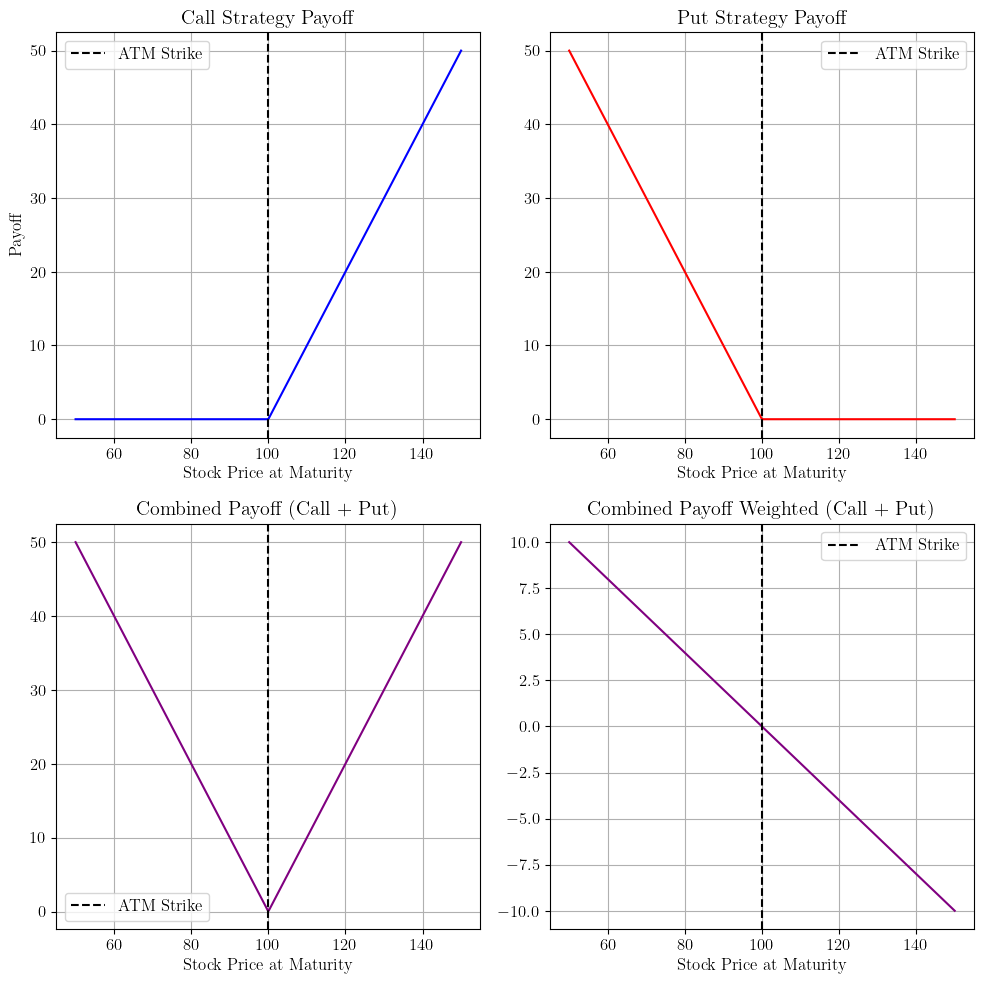

In [ ]:
######## EXPLICIT STRATEGY ########

call_indices_fixed = np.array([4, 4, 4, 4, 4])  
put_indices_fixed = np.array([4, 4, 4, 4, 4])   

call_weights_fixed = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
put_weights_fixed = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  

call_weights_fixed =project_to_sum_one(call_weights_fixed)
put_weights_fixed =project_to_sum_one(put_weights_fixed)

call_strikes_fixed = K_grid[call_indices_fixed]
put_strikes_fixed = K_grid[put_indices_fixed]

pi_fixed= np.array([0.4, -0.2, 0.2, 0.4, 0.2])

S_ATM=S[:,0].mean()

plot_full_option_strategy_payoff(call_strikes_fixed, call_weights_fixed, put_strikes_fixed, put_weights_fixed, pi_fixed, S_ATM)


In [ ]:
######## IMPLICIT STRATEGY FITNESS ########

def simulate_wealth_from_genes(genes):
    try:
        pi = genes[:5]

        pi = project_to_sum_one(pi)

        X_sim = np.ones((M, N+1))

        begin=int(N*11/12)
        for t in range(begin, N+1):
            try:
                A1_1_sum = np.sum(A1_1[:, t, call_indices_fixed] * call_weights_fixed, axis=1)/10
                A2_1_sum = np.sum(A2_1[:, t, call_indices_fixed] * call_weights_fixed, axis=1)/10
                A3_1_sum = np.sum(A3_1[:, t, call_indices_fixed] * call_weights_fixed, axis=1)/10
                A4_1_sum = np.sum(A4_1[:, t, call_indices_fixed] * call_weights_fixed, axis=1)/10

                A1_2_sum = np.sum(A1_2[:, t, put_indices_fixed] * put_weights_fixed, axis=1)/10
                A2_2_sum = np.sum(A2_2[:, t, put_indices_fixed] * put_weights_fixed, axis=1)/10
                A3_2_sum = np.sum(A3_2[:, t, put_indices_fixed] * put_weights_fixed, axis=1)/10
                A4_2_sum = np.sum(A4_2[:, t, put_indices_fixed] * put_weights_fixed, axis=1)/10
            except Exception as e:
                print("Error during option summation at t =", t, ":", e)
                return -1e6

            theta_s = np.sqrt(1 - rho**2) * pi[0] + A1_1_sum * pi[1] + A1_2_sum * pi[2]
            theta_r = nu * pi[0] - b_func(T_tilde, t * dt, kappa_r, lambda_r) * pi[3] + A2_1_sum * pi[1] + A2_2_sum * pi[2]
            theta_v = rho * pi[0] + A3_1_sum * pi[1] + A3_2_sum * pi[2]
            theta_N =  pi[0] + 1/mu*A4_1_sum * pi[1] + 1/mu*A4_2_sum * pi[2]

            v_safe = V[:, t]
            r_safe = r[:, t]

            X_prev = X_sim[:, t-1]
            dX = (
                r_safe * dt
                + theta_s * (lambda_s * v_safe * dt + np.sqrt(v_safe) * dW_s[:, t-1])
                + theta_v * (lambda_v * v_safe * dt + np.sqrt(v_safe) * dW_v[:, t-1])
                + theta_r * (lambda_r * r_safe * dt + sigma_r * np.sqrt(r_safe) * dW_r[:, t-1])
                + theta_N * mu * ( ((lambda_j - lambda_j_q) * v_safe * dt + (N_J[:, t] - lambda_j * v_safe * dt)) )
            )

            X_sim[:, t] = X_prev + X_prev * dX

            if np.any(np.isnan(X_sim[:, t])) or np.any(np.isinf(X_sim[:, t])):
                print(f"Invalid wealth at t={t}")
                return -1e6

        terminal_wealth = X_sim[:, -1]

        if np.any(np.isnan(terminal_wealth)) or np.any(np.isinf(terminal_wealth)):
            print("Invalid terminal wealth.")
            return -1e6
        
        mean_terminal_wealth = np.mean(terminal_wealth)
    
        if mean_terminal_wealth > 0:
            utility = (mean_terminal_wealth ** (1 - gamma)) / (1 - gamma)
        else:
            mean_terminal_wealth=mean_terminal_wealth*-1
            utility = -(mean_terminal_wealth ** (1 - gamma)) / (1 - gamma)

        if np.isnan(utility) or np.isinf(utility):
            print("Utility is invalid:", utility)
            return -1e6

        return utility

    except Exception as e:
        print("Unhandled error in simulation:", e)
        return -1e6

def fitness_func(ga_instance, solution, solution_idx):
    return simulate_wealth_from_genes(solution)

def project_to_sum_one(w):
    return w - (np.sum(w) - 1) / len(w)


In [ ]:

def plot_full_option_strategy_payoff_exp(call_strikes, call_weights, put_strikes, put_weights, pi_weights, S_mean):
    
    S_grid = np.linspace(0.5 * S_mean, 1.5 * S_mean, 500)

    call_payoff = np.zeros_like(S_grid)
    for K, w in zip(call_strikes, call_weights):
        call_payoff += w * np.maximum(S_grid - K, 0)

    put_payoff = np.zeros_like(S_grid)
    for K, w in zip(put_strikes, put_weights):
        put_payoff += w * np.maximum(K - S_grid, 0)

    combined_payoff_weighted = pi_weights[1]*call_payoff + pi_weights[2]*put_payoff
    combined_payoff= call_payoff +put_payoff

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Call
    axes[0,0].plot(S_grid, call_payoff, color="blue")
    axes[0,0].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[0,0].set_title("Call Strategy Payoff")
    axes[0,0].set_xlabel("Stock Price at Maturity")
    axes[0,0].set_ylabel("Payoff")
    axes[0,0].grid(True)
    axes[0,0].legend()

    # Put
    axes[0,1].plot(S_grid, put_payoff, color="red")
    axes[0,1].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[0,1].set_title("Put Strategy Payoff")
    axes[0,1].set_xlabel("Stock Price at Maturity")
    axes[0,1].grid(True)
    axes[0,1].legend()

    # Combined
    axes[1,0].plot(S_grid, combined_payoff, color="purple")
    axes[1,0].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[1,0].set_title("Combined Payoff (Call + Put)")
    axes[1,0].set_xlabel("Stock Price at Maturity")
    axes[1,0].grid(True)
    axes[1,0].legend()

    # Combined weighted
    axes[1,1].plot(S_grid, combined_payoff_weighted, color="purple")
    axes[1,1].axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
    axes[1,1].set_title("Combined Payoff Weighted (Call + Put)")
    axes[1,1].set_xlabel("Stock Price at Maturity")
    axes[1,1].grid(True)
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()


/Users/leajeppesen/anaconda3/lib/python3.10/site-packages/pygad/pygad.py:770: UserWarning: The percentage of genes to mutate (5) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate ({mutation_percent_genes[idx]}) resulted in selecting ({mutation_num_genes[idx]}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
/var/folders/nh/25gr2gcn4rd1mz34g3j0_b8m0000gn/T/ipykernel_13723/192519407.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  return w - (np.sum(w) - 1) / len(w)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Utility: -0.18217740282309472

Optimal Portfolio Weights (stock, calls, puts, bond, money market): [ 0.99332519 -2.9629451   1.01369517  0.98884769  0.96707705]
Call Option Indices: []
Call Option Strikes: []
Call Option Weights: []
Put Option Indices: []
Put Option Strikes: []
Put Option Weights: []
ATM Strike Index: 4
ATM Strike: 100.0
Mean: 100.0


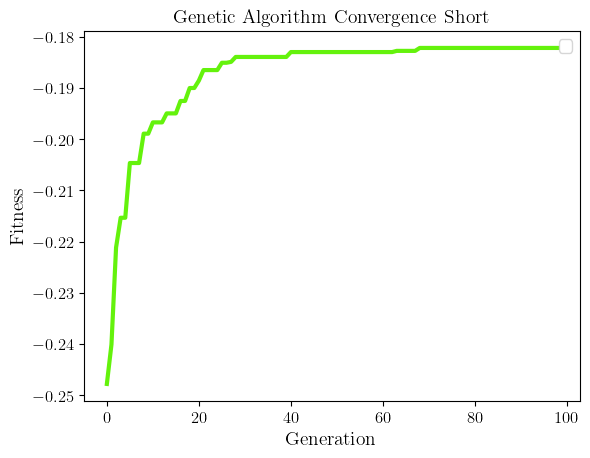

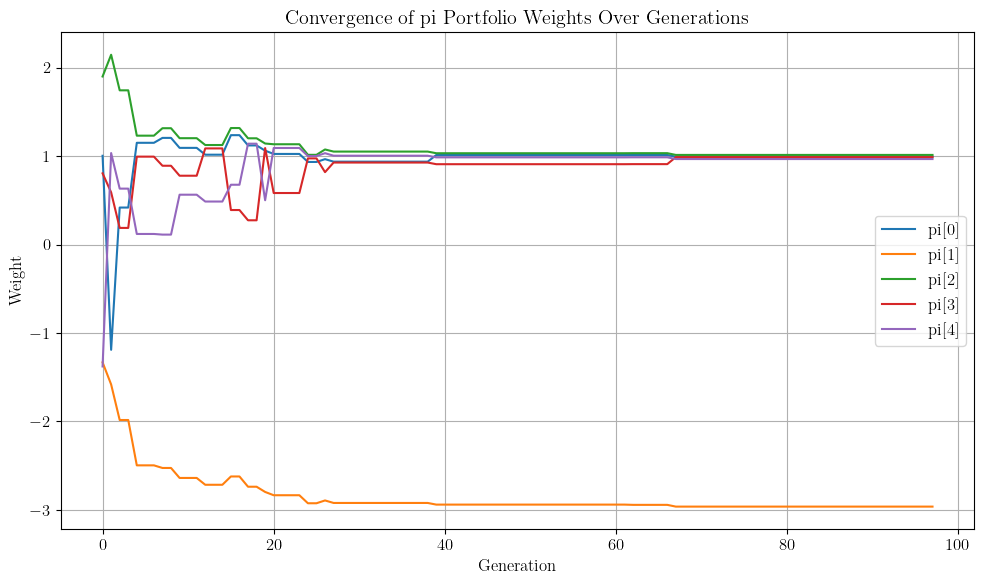

In [ ]:
############ IMPLICIT STRATEGY OPTIMIZATION SINGLE RUN ############

pi_history = []

def on_generation(ga_instance):
    solution, _, _ = ga_instance.best_solution()
    pi = project_to_sum_one(solution[:5])
    pi_history.append(pi)

gene_space_short = [{'low': -2, 'high': 2}] * 5

ga_instance_short = pygad.GA(
        num_generations=100,
        num_parents_mating=10,
        sol_per_pop=30,
        num_genes=5,
        gene_space=gene_space_short,
        fitness_func=fitness_func,
        parent_selection_type="tournament",
        keep_parents=5,
        mutation_percent_genes=(20,5),
        mutation_type="adaptive",
        crossover_type="single_point",
        stop_criteria=["saturate_30"],
        random_seed=MASTER_SEED,
        parallel_processing=["thread", 8],
        on_generation=on_generation
    )

ga_instance_short.run()

solution_short, solution_fitness_short, _ = ga_instance_short.best_solution()
print("Best Utility:", solution_fitness_short)

pi_opt_short= project_to_sum_one(solution_short[:5])
call_weights_opt_short = project_to_sum_one(solution_short[5:10])
put_weights_opt_short = project_to_sum_one(solution_short[10:15])
call_indices_opt_short = np.round(solution_short[15:20]).astype(int)
put_indices_opt_short = np.round(solution_short[20:25]).astype(int)
call_strikes_opt_short = K_grid[call_indices_opt_short]
put_strikes_opt_short = K_grid[put_indices_opt_short]

print("\nOptimal Portfolio Weights (stock, calls, puts, bond, money market):", pi_opt_short)
print("Call Option Indices:", call_indices_opt_short)
call_strikes_opt_short = K_grid[call_indices_opt_short]
print("Call Option Strikes:", call_strikes_opt_short)
print("Call Option Weights:", call_weights_opt_short)
print("Put Option Indices:", put_indices_opt_short)
put_strikes_opt_short = K_grid[put_indices_opt_short]
print("Put Option Strikes:", put_strikes_opt_short)
print("Put Option Weights:", put_weights_opt_short)

atm_strike_idx = np.argmin(np.abs(K_grid - S_mean))
print("ATM Strike Index:", atm_strike_idx)
print("ATM Strike:", K_grid[atm_strike_idx])
S_ATM=S[:,0].mean()
print("Mean:", S_ATM)
ga_instance_short.plot_fitness(title="Genetic Algorithm Convergence Short")

pi_history = np.array(pi_history)

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(pi_history[:, i], label=f"pi[{i}]")
plt.title("Convergence of pi Portfolio Weights Over Generations")
plt.xlabel("Generation")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

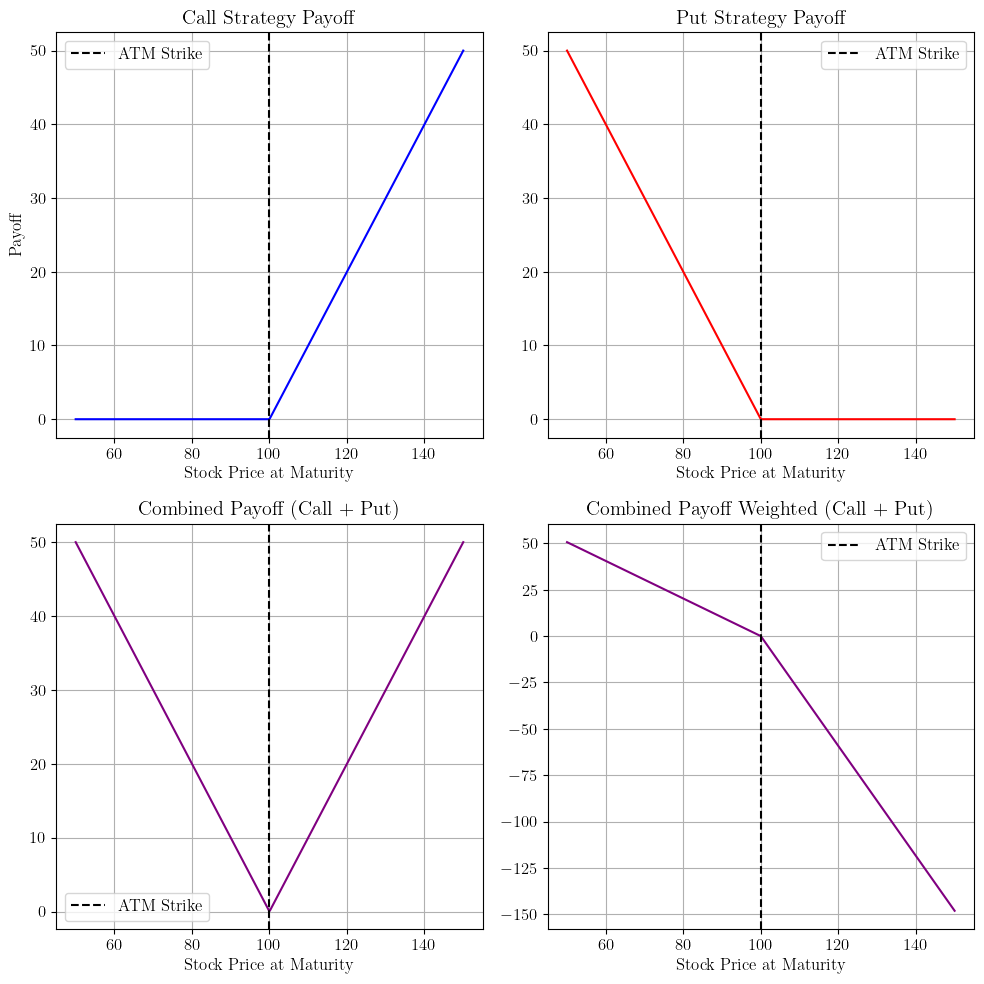

In [16]:
plot_full_option_strategy_payoff_exp(
    call_strikes_fixed,
    call_weights_fixed,
    put_strikes_fixed,
    put_weights_fixed,
    pi_opt_short,
    S_ATM
)

Processing:   0%|                                                            | 0/10 [00:00<?, ?it/s]/Users/leajeppesen/anaconda3/lib/python3.10/site-packages/pygad/pygad.py:770: UserWarning: The percentage of genes to mutate (5) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate ({mutation_percent_genes[idx]}) resulted in selecting ({mutation_num_genes[idx]}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
Processing: 100%|██████████████████████████████████████████████████| 10/10 [37:31<00:00, 225.12s/it]


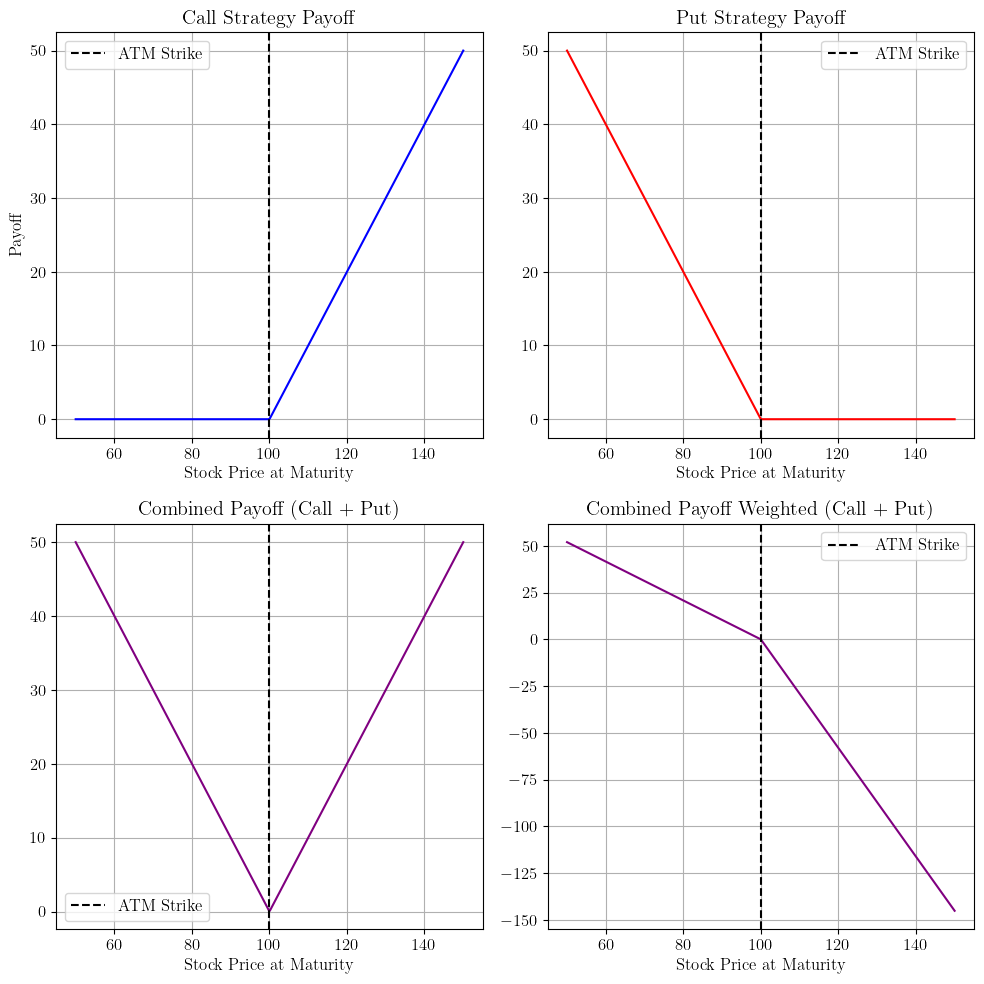


Optimal Portfolio Weights (stock, derivatives, bond, money market): [ 0.97042246 -2.90369584  1.03985496  0.9856442   0.90777422]
Utility: -0.18540288597380564


In [ ]:
############ EXPLICIT AVERAGE STRATEGY OPTIMIZATION ############

pi_opt_all_short_exp = []
S_ATM_all_short_exp = []
utility_short_exp = []

for u in tqdm(range(0, ga_runs), desc="Processing", ncols=100):
    gene_space_exp_short = [{'low': -2, 'high': 2}] * 5

    ga_instance_exp_short = pygad.GA(
                num_generations=100,
                num_parents_mating=10,
                sol_per_pop=30,
                num_genes=5,
                gene_space=gene_space_short,
                fitness_func=fitness_func,
                parent_selection_type="tournament",
                keep_parents=5,
                mutation_percent_genes=(20,5),
                mutation_type="adaptive",
                crossover_type="single_point",
                stop_criteria=["saturate_30"],
                random_seed=int(seeds_for_runs[u]),
                parallel_processing=["thread", 8],   
            )

    ga_instance_exp_short.run()

    solution_short_exp, solution_fitness_short_exp, _ = ga_instance_exp_short.best_solution()

    pi_opt_short_exp= project_to_sum_one(solution_short_exp[:5])
    S_ATM=S[:,0].mean()

    pi_opt_all_short_exp.append(pi_opt_short_exp)
    S_ATM_all_short_exp.append(S_ATM)
    utility_short_exp.append(solution_fitness_short_exp)

pi_opt_avg_short_exp = np.mean(pi_opt_all_short_exp, axis=0)
S_ATM_avg_short_exp = np.mean(S_ATM_all_short_exp, axis=0)
utility_avg_short_exp = np.mean(utility_short_exp, axis=0)

plot_full_option_strategy_payoff_exp(call_strikes_fixed, call_weights_fixed, put_strikes_fixed, put_weights_fixed, pi_opt_avg_short_exp, S_ATM_avg_short_exp)

print("\nOptimal Portfolio Weights (stock, derivatives, bond, money market):", pi_opt_avg_short_exp)
print("Utility:", utility_avg_short_exp)


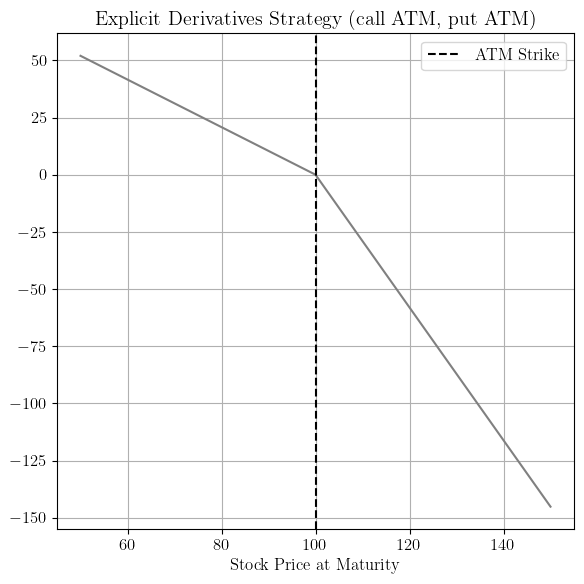

In [ ]:
S_grid = np.linspace(0.5 * S_mean, 1.5 * S_mean, 500)

call_payoff = np.zeros_like(S_grid)
for K, w in zip(call_strikes_fixed, call_weights_fixed):
    call_payoff += w * np.maximum(S_grid - K, 0)

put_payoff = np.zeros_like(S_grid)
for K, w in zip(put_strikes_fixed, put_weights_fixed):
    put_payoff += w * np.maximum(K - S_grid, 0)

combined_payoff_weighted = pi_opt_avg_short_exp[1]*call_payoff + pi_opt_avg_short_exp[2]*put_payoff
combined_payoff= call_payoff +put_payoff

# Plot
plt.figure(figsize=(6, 6))
plt.plot(S_grid, combined_payoff_weighted, color="gray")
plt.axvline(S_mean, color="black", linestyle="--", label="ATM Strike")
plt.title("Explicit Derivatives Strategy (call ATM, put ATM)")
plt.xlabel("Stock Price at Maturity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Full_model_explicit_atm.png", dpi=600) 
plt.show()


In [19]:
print(" & ".join([f"{w:.3f}" for w in pi_opt_avg_short_exp]) + " \\\\")

0.970 & -2.904 & 1.040 & 0.986 & 0.908 \\


In [ ]:

n_runs = ga_runs  


pi_opt_mean_short = np.mean(pi_opt_all_short_exp, axis=0)
utility_mean_short = np.mean(utility_short_exp, axis=0)


pi_opt_std_short = np.std(pi_opt_all_short_exp, axis=0, ddof=1)
utility_std_short = np.std(utility_short_exp, axis=0, ddof=1)


sem_pi = pi_opt_std_short / np.sqrt(n_runs)
sem_utility = utility_std_short / np.sqrt(n_runs)


z = stats.norm.ppf(0.975)  # 1.96 for 95% CI
ci_pi = np.stack((pi_opt_mean_short - z * sem_pi, pi_opt_mean_short + z * sem_pi), axis=1)
ci_utility = [utility_mean_short - z * sem_utility, utility_mean_short + z * sem_utility]


print("Mean Utility:", utility_mean_short)
print("Std. Dev. Utility:", utility_std_short)
print("95% CI for Utility:", ci_utility)
print("Mean Portfolio Weights:", pi_opt_mean_short)
print("Std. Dev. Portfolio Weights:", pi_opt_std_short)
print("95% CI for Portfolio Weights:\n", ci_pi)

Mean Utility: -0.18540288597380564
Std. Dev. Utility: 0.0035476066876820155
95% CI for Utility: [-0.1876016749754014, -0.18320409697220988]
Mean Portfolio Weights: [ 0.97042246 -2.90369584  1.03985496  0.9856442   0.90777422]
Std. Dev. Portfolio Weights: [0.08833238 0.09684981 0.09598967 0.08432077 0.18176911]
95% CI for Portfolio Weights:
 [[ 0.91567449  1.02517042]
 [-2.96372287 -2.84366881]
 [ 0.98036104  1.09934888]
 [ 0.93338261  1.0379058 ]
 [ 0.79511463  1.02043382]]
